<a href="https://colab.research.google.com/github/gokmenkilic/ML-Intro/blob/gk%2Ftests/Physics_Predicting_Masses_in_Gravitational_Waves_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Gravitational waves regression

In this notebook, we attempt to build a neural network to estimate two masses in gravitational waves.

Gravitational waves are disturbances in the curvature of spacetime, generated by accelerated masses, that propagate as waves outward from their source at the speed of light. The gravitational waves used in this tutorial are generated with two masses $m_1$ and $m_2$. The detial description of the data are published in [LALSuite IMRPhenomD generator](https://arxiv.org/pdf/1508.07250.pdf).

The aim of this work is to estimate two masses $m_1$ and $m_2$ using 1d convolutional and dense layers.


In [1]:
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Multiply, Add, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# sklearn
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import sklearn.datasets
from sklearn.preprocessing import StandardScaler

# helpers
import urllib.request
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join

# need some certainty in data processing
np.random.seed(1234)
tf.random.set_seed(1234)

## Data Setup & Google Colab Environment

The dataset is hosted publicly by DiRAC on COSMA. **Please make sure you run the cell below to download the data.**

To access the data from COSMA, you need to:

1. Run the first cell;
2. It will create a folder called sciml-workshop-data.
3. It will download the necessary HDF5 files directly into that folder.
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [2]:
# data setup configuration
data_path = 'sciml-workshop-data'
full_dir = os.path.join(data_path, 'Physics')
os.makedirs(full_dir, exist_ok=True)

base_url = "https://virgodb.cosma.dur.ac.uk/public/dc-kili1/sciml-workshop-data/Physics/"
files_to_download = ["gravitational_wave_dataset.npy"]

In [3]:
for filename in files_to_download:
    path = os.path.join(full_dir, filename)

    if not os.path.exists(path):
        urllib.request.urlretrieve(base_url + filename, path)

---

# 1. Load the dataset

### Read raw data

The data is stored in 'Physics/gravitational_wave_dataset.npz', containing 2,000 signals: 1,000 examples of signals and 1,000 examples of pure noise. The signals are 1 second long with a sample rate of 8196. We will use 1,000 examples of signals for a regression task.

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
grav_wave = np.load(join(data_path, 'Physics/gravitational_wave_dataset.npy'), allow_pickle=True)
```
    
</p>
</details>

In [4]:
grav_wave = np.load(join(data_path, 'Physics/gravitational_wave_dataset.npy'), allow_pickle=True)

In [5]:
def prepare_datset(X, target = 'regression'):
    if target == 'regression':
        x = np.expand_dims(np.sum(np.stack(X[:1000, 2]), axis = -1), axis = -1).astype(np.float32)
        y = np.stack([[w[0] for w in  grav_wave[j, [3, 4]]] for j in np.arange(1000)])
        y = y.reshape(len(x), 2).astype(np.float32)

    elif target == 'classification':
        x = np.expand_dims(np.sum(np.stack(X[:, 1]), axis = -1), axis = -1)
        y = X[:, 0].astype(np.int)

    return x, y

Prepare a dataset for a regression task using the prepare_dataset function and split it using the train_test_split funtion

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
x, y = prepare_datset(grav_wave, target = 'regression')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

print('x_train shape: ', x_train.shape)
print('y_train shape: ', y_train.shape)
print('x_test shape: ', x_test.shape)
print('y_test shape: ', y_test.shape)    
```
    
</p>
</details>

In [6]:
x, y = prepare_datset(grav_wave, target = 'regression')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

print('x_train shape: ', x_train.shape)
print('y_train shape: ', y_train.shape)
print('x_test shape: ', x_test.shape)
print('y_test shape: ', y_test.shape)

x_train shape:  (800, 8192, 1)
y_train shape:  (800, 2)
x_test shape:  (200, 8192, 1)
y_test shape:  (200, 2)


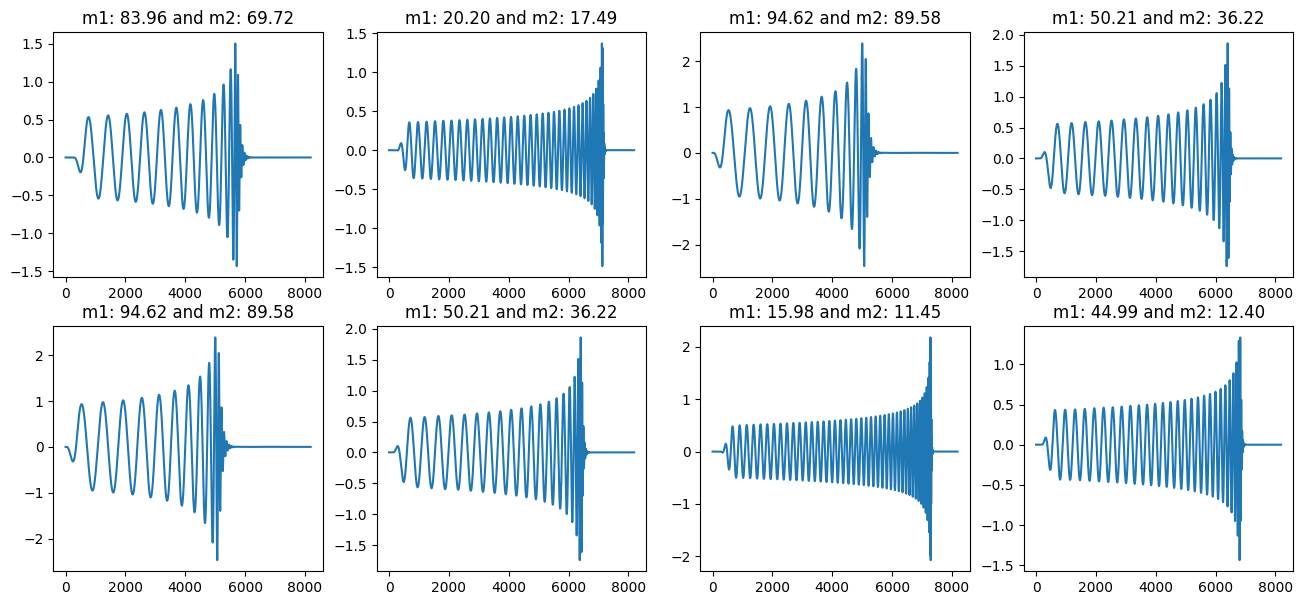

In [7]:
fig, axes = plt.subplots(2, 4, figsize = (16, 7))

rnd_idx = np.random.choice(len(x_train), 8)
for i in range(2):
    for j in range(4):
        axes[i][j].plot(x_train[rnd_idx[2*i+j]])
        axes[i][j].set_title('m1: {:.2f} and m2: {:.2f}'.format(y_train[rnd_idx[2*i+j]][0], y_train[rnd_idx[2*i+j]][1]))

---

# 2. Build the network

We will build a linear regression using sklearn and a 1D-convolutional neural network to compare their results.

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# fit linear regression model
model = LinearRegression().fit(x_train.reshape(-1, 8192), y_train)
# make predictions
y_train_pred = model.predict(x_train.reshape(-1, 8192))
y_test_pred = model.predict(x_test.reshape(-1, 8192))
```
    
</p>
</details>


In [8]:
# fit linear regression model
model = LinearRegression().fit(x_train.reshape(-1, 8192), y_train)
# make predictions
y_train_pred = model.predict(x_train.reshape(-1, 8192))
y_test_pred = model.predict(x_test.reshape(-1, 8192))

In [9]:
# compute some fitting error
print('MSE on the train set = %f ' % metrics.mean_squared_error(y_train, y_train_pred))
print('MAE on the train set = %f ' % metrics.mean_absolute_error(y_train, y_train_pred))
print('MSE on the test set = %f ' % metrics.mean_squared_error(y_test, y_test_pred))
print('MAE on the test set = %f ' % metrics.mean_absolute_error(y_test, y_test_pred))

MSE on the train set = 266.212341 
MAE on the train set = 12.578650 
MSE on the test set = 17245.621094 
MAE on the test set = 40.384384 


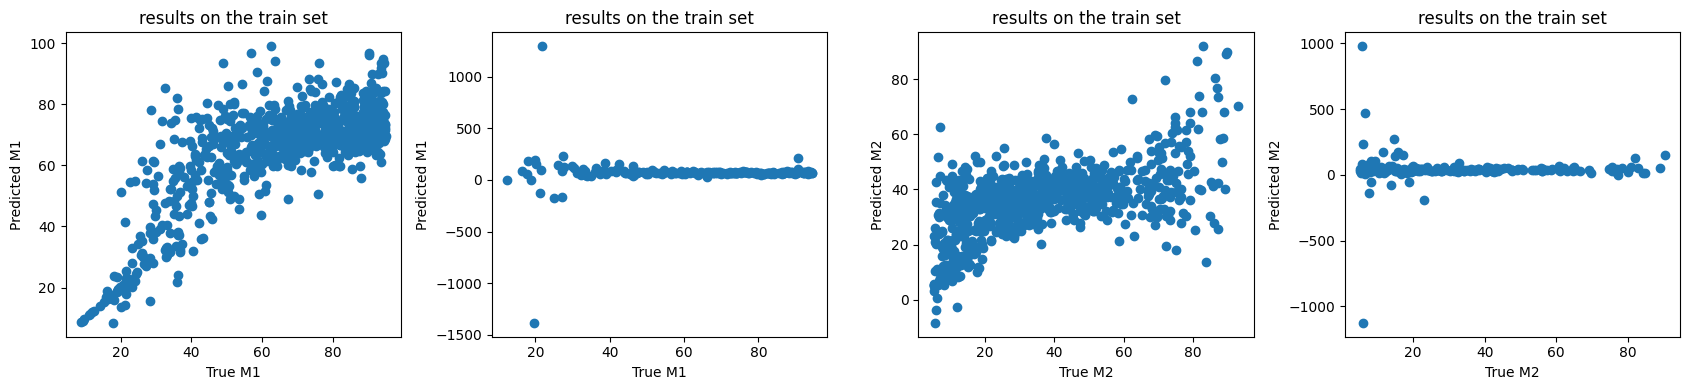

In [10]:
fig, axes = plt.subplots(1, 4, figsize = (17, 4))

axes[0].scatter(y_train[:, 0], y_train_pred[:, 0])
axes[0].set_title('results on the train set')
axes[0].set_xlabel('True M1')
axes[0].set_ylabel('Predicted M1')

axes[1].scatter(y_test[:, 0], y_test_pred[:, 0])
axes[1].set_title('results on the train set')
axes[1].set_xlabel('True M1')
axes[1].set_ylabel('Predicted M1')

axes[2].scatter(y_train[:, 1], y_train_pred[:, 1])
axes[2].set_title('results on the train set')
axes[2].set_xlabel('True M2')
axes[2].set_ylabel('Predicted M2')

axes[3].scatter(y_test[:, 1], y_test_pred[:, 1])
axes[3].set_title('results on the train set')
axes[3].set_xlabel('True M2')
axes[3].set_ylabel('Predicted M2')

fig.tight_layout()

### Use 1D-convolutional layers to build a neural network

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
model = Sequential()
model.add(Input(shape=(x_train.shape[1],1,)))

model.add(Conv1D(filters=16, kernel_size=7, strides = 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(filters=32, kernel_size=7, strides = 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(2))        

opt = tf.keras.optimizers.Adam(0.01)
model.compile(loss="mse", optimizer=opt)



stopper=EarlyStopping(monitor ="val_loss", min_delta=0.0,verbose=1,
                      mode="min", restore_best_weights=True,patience=5)
history = model.fit(x_train, y_train, epochs=99, batch_size=64,
                             validation_split = 0.2 ,callbacks=[stopper])
```
    
</p>
</details>

In [11]:
model = Sequential()
model.add(Input(shape=(x_train.shape[1],1,)))

model.add(Conv1D(filters=16, kernel_size=7, strides = 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(filters=32, kernel_size=7, strides = 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(2))

opt = tf.keras.optimizers.Adam(0.01)
model.compile(loss="mse", optimizer=opt)



stopper=EarlyStopping(monitor ="val_loss", min_delta=0.0,verbose=1,
                      mode="min", restore_best_weights=True,patience=5)
history = model.fit(x_train, y_train, epochs=99, batch_size=64,
                             validation_split = 0.2 ,callbacks=[stopper])

Epoch 1/99
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 556ms/step - loss: 4297.9951 - val_loss: 2952.2068
Epoch 2/99
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 714ms/step - loss: 2869.6848 - val_loss: 1269.8640
Epoch 3/99
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 528ms/step - loss: 736.9329 - val_loss: 359.0046
Epoch 4/99
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 582ms/step - loss: 527.8340 - val_loss: 334.2154
Epoch 5/99
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 571ms/step - loss: 389.9188 - val_loss: 285.9713
Epoch 6/99
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 522ms/step - loss: 329.7719 - val_loss: 253.1878
Epoch 7/99
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 672ms/step - loss: 305.5562 - val_loss: 236.2206
Epoch 8/99
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 566ms/step - loss: 282.8809 - val_loss: 231.2263
Epoch 9/99
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 598ms/step - loss: 261.3938 - val_loss: 223.4874
Epoch 10/99
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 555ms/step - loss: 250.6997 - val_loss: 215.2081
Epoch 11/99
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 580ms/step - loss: 243.7362 - val_loss: 201.0894
Epo

# 3. Analyse results

### prediction

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)
```
    
</p>
</details>

In [12]:
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


In [13]:
# compute some fitting error
print('MSE on the train set = %f ' % metrics.mean_squared_error(y_train, y_train_pred))
print('MAE on the train set = %f ' % metrics.mean_absolute_error(y_train, y_train_pred))
print('MSE on the test set = %f ' % metrics.mean_squared_error(y_test, y_test_pred))
print('MAE on the test set = %f ' % metrics.mean_absolute_error(y_test, y_test_pred))

MSE on the train set = 67.016510 
MAE on the train set = 6.496350 
MSE on the test set = 117.058273 
MAE on the test set = 8.836714 


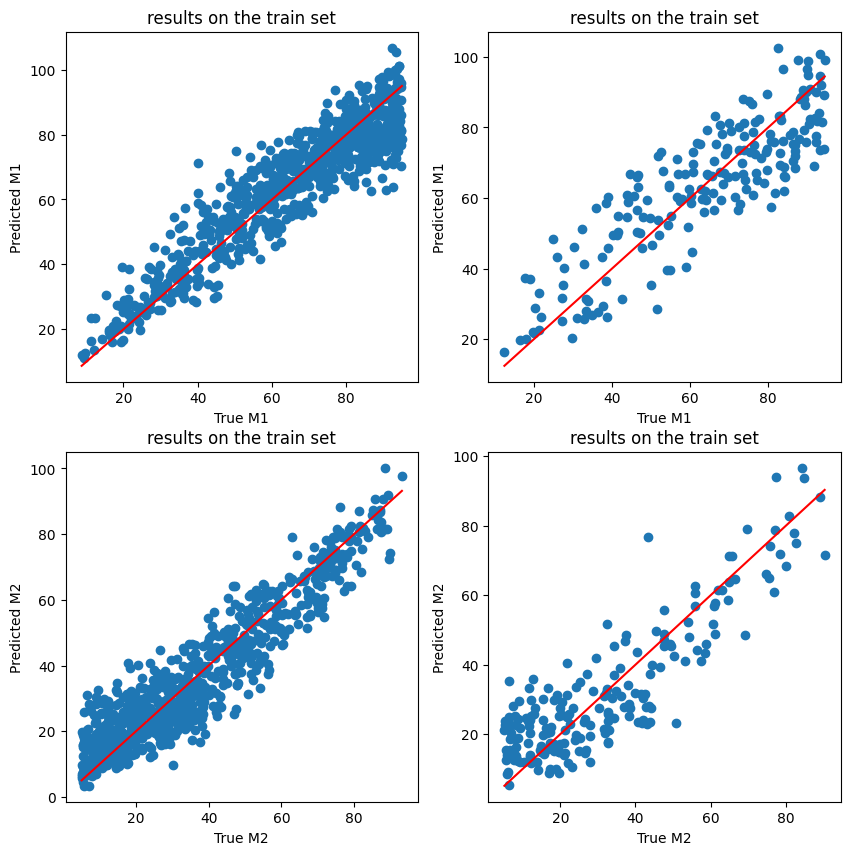

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (10, 10))

axes[0][0].scatter(y_train[:, 0], y_train_pred[:, 0])
axes[0][0].plot([y_train[:, 0].min(), y_train[:, 0].max()], [y_train[:, 0].min(), y_train[:, 0].max()],'r')
axes[0][0].set_title('results on the train set')
axes[0][0].set_xlabel('True M1')
axes[0][0].set_ylabel('Predicted M1')


axes[0][1].scatter(y_test[:, 0], y_test_pred[:, 0])
axes[0][1].plot([y_test[:, 0].min(), y_test[:, 0].max()], [y_test[:, 0].min(), y_test[:, 0].max()],'r')
axes[0][1].set_title('results on the train set')
axes[0][1].set_xlabel('True M1')
axes[0][1].set_ylabel('Predicted M1')


axes[1][0].scatter(y_train[:, 1], y_train_pred[:, 1])
axes[1][0].plot([y_train[:, 1].min(), y_train[:, 1].max()], [y_train[:, 1].min(), y_train[:, 1].max()],'r')
axes[1][0].set_title('results on the train set')
axes[1][0].set_xlabel('True M2')
axes[1][0].set_ylabel('Predicted M2')


axes[1][1].scatter(y_test[:, 1], y_test_pred[:, 1])
axes[1][1].plot([y_test[:, 1].min(), y_test[:, 1].max()], [y_test[:, 1].min(), y_test[:, 1].max()],'r')
axes[1][1].set_title('results on the train set')
axes[1][1].set_xlabel('True M2')
axes[1][1].set_ylabel('Predicted M2')
plt.show()


---

# 4. Exercises

* Change some hyperparameters in `model.compile()` and `model.fit()` to see their effects (see reference of [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model));
* Change the architeture and activation functions of neural networks to improve the performance on the test set